<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning3/blob/master/notebook/chap04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 46.0 MB/s eta 0:00:00


# 4. 識別 ー統計的手法ー

## 例題 4.2

Weather.nominal データでナイーブベイズ識別を行え。

In [1]:
# 4章で用いるライブラリ
import numpy as np
import pandas as pd
import math
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
# Jupyter notebook で出力を見やすくするための設定
%precision 3
np.set_printoptions(precision=3, suppress=True)

weatherデータをpandasのDataFrame形式で読み込みます。

In [4]:
weather = fetch_openml(data_id=40739)
df = weather.data
df

/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:1035: UserWarning: Version 1 of dataset weather.nominal is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/5216130/weather.nominal.arff
  warn(


,outlook,temperature,humidity,windy,play
0,sunny,hot,high,FALSE,no
1,sunny,hot,high,TRUE,no
2,overcast,hot,high,FALSE,yes
3,rainy,mild,high,FALSE,yes
4,rainy,cool,normal,FALSE,yes
5,rainy,cool,normal,TRUE,no
6,overcast,cool,normal,TRUE,yes
7,sunny,mild,high,FALSE,no
8,sunny,cool,normal,FALSE,yes
9,rainy,mild,normal,FALSE,yes


パターン行列Xと正解yを取り出します。  

In [5]:
X = df.drop('play', axis=1)
y = df['play']

特徴はOrdinalEncoderで数値ベクトルに変換します。
OrdinalEncoderは $n$ 種類のカテゴリ特徴を $0,\dots,n-1$の整数に置き換えます。

In [6]:
oe = OrdinalEncoder()
X_enc = oe.fit_transform(X)

In [7]:
oe.categories_

[array(['overcast', 'rainy', 'sunny'], dtype=object),
 array(['cool', 'hot', 'mild'], dtype=object),
 array(['high', 'normal'], dtype=object),
 array(['FALSE', 'TRUE'], dtype=object)]

In [8]:
X_enc

array([[2., 1., 0., 0.],
       [2., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 2., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 0., 0.],
       [2., 0., 1., 0.],
       [1., 2., 1., 0.],
       [2., 2., 1., 1.],
       [0., 2., 0., 1.],
       [0., 1., 1., 0.],
       [1., 2., 0., 1.]])

ナイーブベイズ識別器[CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html)の学習を行います。デフォルトでラプラス推定を行っています。

In [9]:
clf = CategoricalNB()
clf.fit(X_enc, y)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,min_categories,None


In [10]:
clf.classes_

array(['no', 'yes'], dtype='<U3')

学習した統計モデルの中身を見ます。category\_count\_属性では、各特徴の情報が一つの行列で表されて、行方向がクラス、列方向が特徴の値です。データセット中の頻度が単純にカウントされているだけで、この属性にはスムージングの情報は入っていません。

In [11]:
co = clf.category_count_
for i, c in enumerate(co):
  print(df.columns[i])
  for r in c:
    print(r)

outlook
[0. 2. 3.]
[4. 3. 2.]
temperature
[1. 2. 2.]
[3. 2. 4.]
humidity
[4. 1.]
[3. 6.]
windy
[2. 3.]
[6. 3.]


スムージングされた結果は、feature\_log\_prob\_属性に入っています。

In [12]:
fe = clf.feature_log_prob_
for i, f in enumerate(fe):
    print(df.columns[i])
    for r in f:
        print(r)

outlook
[-2.079 -0.981 -0.693]
[-0.875 -1.099 -1.386]
temperature
[-1.386 -0.981 -0.981]
[-1.099 -1.386 -0.875]
humidity
[-0.336 -1.253]
[-1.012 -0.452]
windy
[-0.847 -0.56 ]
[-0.452 -1.012]


outlook特徴を表す0番目の行列から、クラスが yes（1行目）、特徴の値が overcast（0列目）の値を取り出して、スムージングができていることを検算します。yes が9事例、そのうち overcast が4事例なので、$\log\frac{4+1}{9+3}$を求め、その値が上記データと一致していることを確認します。

In [13]:
math.log(5/12)

-0.875

In [14]:
print(f'{fe[0][1][0]:.3f}')

-0.875


判定結果を得るには、predict_probaメソッドを呼び出します。

例として (sunny, hot, high, FALSE) の判定結果を求めます。結果は、\[noの確率, yesの確率\] という要素を持ったndarrayのリストで帰ってきます。

In [15]:
clf.predict_proba([X_enc[0]])

array([[0.688, 0.312]])

検算をする場合は、scikit-learnでは事前確率のスムージングを行っていないことに注意してください。

In [ ]:
p = (3/12)*(3/12)*(4/11)*(7/11)*(9/14)
n = (4/8)*(3/8)*(5/7)*(3/7)*(5/14)
p / (p + n)

0.312

#演習問題 4.1

スムージングを行わない方法でナイーブベイズ識別器の学習を行い、Weather.nominal データ中の特定のデータに対する識別結果の確率を求め、その確率計算が正しいことを検算してください。


[CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) のマニュアルには、スムージングを行わないようにするにはインスタンスを作るときに `set alpha=0, force_alpha=True` とするように書かれていますが、警告が出るので `alpha=1.0e-10` と小さい値にして計算結果に影響が出ないようにしています。


In [7]:
clf2 = CategoricalNB(alpha=1.0e-10)
clf2.fit(X_enc, y)

prob = clf2.predict_proba([X_enc[0]])
print(f'prob1 = {prob}')

p=(2/9)*(2/9)*(3/9)*(6/9)*(9/14)
n=(3/5)*(2/5)*(4/5)*(2/5)*(5/14)
print(f'prob2 = {p/(p+n):.3}')

prob1 = [[0.795 0.205]]
prob2 = 0.205


# ベイジアンネットワーク

ライブラリ [pgmpy](https://pgmpy.org/)を用いてベイジアンネットワークの計算を行います。2025年10月時点の最新バージョンは 1.0.0 です。

In [8]:
!pip install -U pgmpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 49.7 MB/s eta 0:00:00


In [9]:
# ベイジアンネットワークで用いるライブラリ
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, ApproxInference
from pgmpy.estimators import HillClimbSearch, BayesianEstimator

In [10]:
model = DiscreteBayesianNetwork([('Rain', 'Wet grass')])
cpd_r = TabularCPD(variable='Rain', variable_card=2, values=[[0.6], [0.4]])
cpd_w = TabularCPD(variable='Wet grass', variable_card=2,
                   values=[[0.8, 0.1],
                           [0.2, 0.9]],
                   evidence=['Rain'], evidence_card=[2])
model.add_cpds(cpd_r, cpd_w)
#model.check_model()

In [11]:
print(cpd_r)

+---------+-----+
| Rain(0) | 0.6 |
+---------+-----+
| Rain(1) | 0.4 |
+---------+-----+


In [12]:
print(cpd_w)

+--------------+---------+---------+
| Rain         | Rain(0) | Rain(1) |
+--------------+---------+---------+
| Wet grass(0) | 0.8     | 0.1     |
+--------------+---------+---------+
| Wet grass(1) | 0.2     | 0.9     |
+--------------+---------+---------+


何も観測されていない状況で「芝が濡れている」(Wet grass=1)の確率を求める

In [13]:
infer = VariableElimination(model)
w_dist = infer.query(['Wet grass'])
print(w_dist)

+--------------+------------------+
| Wet grass    |   phi(Wet grass) |
+==============+==================+
| Wet grass(0) |           0.5200 |
+--------------+------------------+
| Wet grass(1) |           0.4800 |
+--------------+------------------+


「芝が濡れている」ことが観測されたときの「雨が降った」(Rain=1)確率を求める。「雨が降る」事前確率0.4よりもかなり大きくなっていることを確認。


In [14]:
print(infer.query(['Rain'], evidence={'Wet grass': 1}))

+---------+-------------+
| Rain    |   phi(Rain) |
+=========+=============+
| Rain(0) |      0.2500 |
+---------+-------------+
| Rain(1) |      0.7500 |
+---------+-------------+


### ベイジアンネットワークの学習

クラスを表すplayを最初の列に移動


In [15]:
df2 = df.reindex(columns=['play', 'outlook', 'temperature', 'humidity', 'windy'])
df2

,play,outlook,temperature,humidity,windy
0,no,sunny,hot,high,FALSE
1,no,sunny,hot,high,TRUE
2,yes,overcast,hot,high,FALSE
3,yes,rainy,mild,high,FALSE
4,yes,rainy,cool,normal,FALSE
5,no,rainy,cool,normal,TRUE
6,yes,overcast,cool,normal,TRUE
7,no,sunny,mild,high,FALSE
8,yes,sunny,cool,normal,FALSE
9,yes,rainy,mild,normal,FALSE


In [16]:
est = HillClimbSearch(data=df2)
dag = est.estimate(scoring_method='k2')
edges = dag.edges()
nodes = dag.nodes()
print(edges)
print(nodes)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('play', 'outlook'), ('play', 'humidity'), ('temperature', 'outlook'), ('humidity', 'temperature'), ('humidity', 'outlook'), ('windy', 'outlook')]
['play', 'outlook', 'temperature', 'humidity', 'windy']


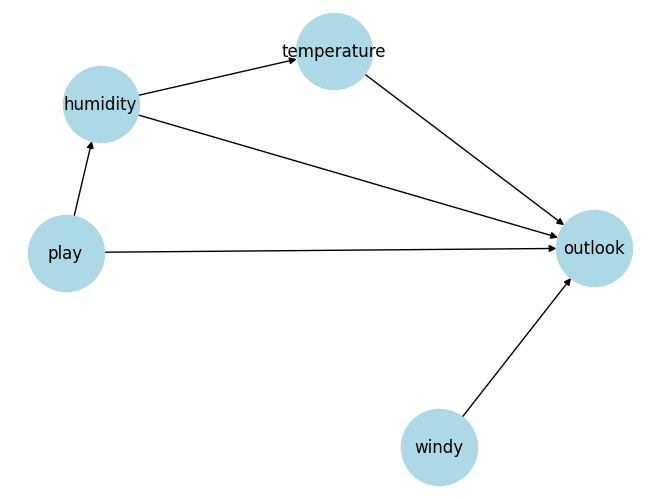

In [17]:
# 学習されたベイジアンネットワークの表示
import networkx as nx
import matplotlib.pyplot as plt

# 有向グラフを作成
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# グラフ描画
nx.draw(G, with_labels=True, arrows=True,
        node_size=3000, node_color='lightblue')
plt.show()

条件付き確率表(cpd)を表示。2番目のcpdは、親ノードの値の組み合わせが多いので表示が省略されている

In [18]:
model = DiscreteBayesianNetwork(dag)
model.fit(df2, estimator=BayesianEstimator, prior_type='K2') # cpds を計算
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd, '\n')

+-----------+-------+
| play(no)  | 0.375 |
+-----------+-------+
| play(yes) | 0.625 |
+-----------+-------+ 

+-------------------+-----+-------------------+
| humidity          | ... | humidity(normal)  |
+-------------------+-----+-------------------+
| play              | ... | play(yes)         |
+-------------------+-----+-------------------+
| temperature       | ... | temperature(mild) |
+-------------------+-----+-------------------+
| windy             | ... | windy(TRUE)       |
+-------------------+-----+-------------------+
| outlook(overcast) | ... | 0.25              |
+-------------------+-----+-------------------+
| outlook(rainy)    | ... | 0.25              |
+-------------------+-----+-------------------+
| outlook(sunny)    | ... | 0.5               |
+-------------------+-----+-------------------+ 

+------------------+--------------------+---------------------+
| play             | play(no)           | play(yes)           |
+------------------+------------------

特徴ベクトル各次元のすべての値が分かっている場合の識別

In [19]:
X_test = pd.DataFrame([['overcast', 'mild', 'high', 'FALSE']], columns=['outlook', 'temperature', 'humidity', 'windy'])
X_test

,outlook,temperature,humidity,windy
0,overcast,mild,high,FALSE


In [20]:
y_prob = model.predict_probability(X_test)
y_prob

,play_no,play_yes
0,0.540984,0.459016


特徴ベクトルの一部しか分かっていない場合の識別

In [21]:
infer = VariableElimination(model)
w_dist = infer.query(['play'], evidence={'outlook': 'overcast'})
print(w_dist)

+-----------+-------------+
| play      |   phi(play) |
+===========+=============+
| play(no)  |      0.3219 |
+-----------+-------------+
| play(yes) |      0.6781 |
+-----------+-------------+


近似計算の例

In [22]:
infer = ApproxInference(model)
w_dist = infer.query(['play'], evidence={'outlook': 'overcast'})
print(w_dist)

  0%|          | 0/10000 [00:00<?, ?it/s]

+-----------+-------------+
| play      |   phi(play) |
+===========+=============+
| play(no)  |      0.3185 |
+-----------+-------------+
| play(yes) |      0.6815 |
+-----------+-------------+


/usr/local/lib/python3.12/dist-packages/pgmpy/inference/ApproxInference.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples.groupby(variables).size() / samples.shape[0], state_names


## 参考

* Naive Bayes https://scikit-learn.org/stable/modules/naive_bayes.html